In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

In [2]:
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

In [3]:
tf.__version__

'2.0.0-dev20190715'

In [4]:
tfp.__version__

'0.8.0'

더 빠른 학습을 위해(GPU확인)

In [5]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

loss function : negative log-likelihood

In [6]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

데이터 준비

In [10]:
def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

In [11]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

In [12]:
y, x, x_tst = load_dataset()

Case1. No Uncertainty(Simple Linear Regression)  

inputs에 의존하는 위치(평균)을 중심으로한 척도1의 정규 분포를 사용하여 라벨을 모델링한다.  
TFP의 tfp.layers.DistributionLambda 레이어는 tfd.Distribution의 인스턴스를 반환한다.

In [13]:
# Build model.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

In [14]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

W0402 13:15:00.127492 139893707798272 deprecation.py:323] From /home/ubuntu/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


In [15]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.13275808
5.128968


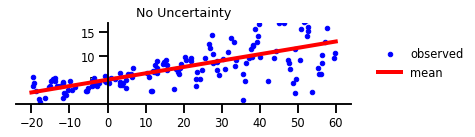

In [16]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.title("No Uncertainty")
ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

따라서, 데이터의 전반적인 추세(파란색 점)에 대한 모델의 예측 평균(빨간색 선)을 관측할 수 있다.

Case2 : Alegtoric Uncertainty(Data Uncertainty)

라벨(y) 분포의 평균을 예측하는 것 외에, 표준편차도 예측한다. 동일한 방식으로 훈련하고 예측을 구성한 후에 x의 함수로서 y의 가변성에 대한 의미있는 예측을 얻을 수 있다.

In [19]:
# Build model.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t[..., :1],
                               scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

In [20]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

In [21]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[0.12132087 0.9924036 ]
[ 5.206389 11.793966]


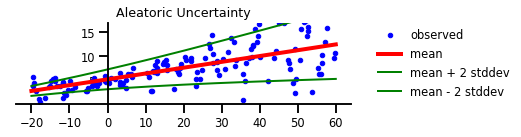

In [22]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.title("Aleatoric Uncertainty")
ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

나아진 결과과 보인다. 모델의 결과로 x가 커질수록 y값이 무엇이어야 하는지에 대해 불확실성을 얻을 수 있다. 이런 불활실성을 aleatoric uncertainty(data uncertainty)라 부른다. 왜냐하면 이것은 데이터에 내재된 근본적인 변화량을 나타내기 때문이다.  
주어진 문제의 data uncertainty를 계량함으로서 더 나은 결과를 예측했지만, 이 문제의 유일한 불확실성은 아니다. 더 나아가기 전에, 불확실성의 근원을 생각해보자.

Case3 : Epicstemic Uncertainty(Model Uncertainty)

데이터의 노이즈는 x와 y의 선형 관계의 매개변수를 완적히 확신할 수 없다는 것을 의미한다. 예를 들어, Case2에서 발견한 y의 기울기가 타당한것 같지만, 확실히 알 수 없다. 아마 약간 더 얕거나 더 가파른 기울기가 더 합리적일 수도 있다. 이런 종류의 불확실성을 episemic uncertainty(model uncertainty)라 부른다. epistemic unertainty는 더 많은 데이터를 이용함으로 불확실성을 줄일 수 있다.  
불확실성을 계량하기 위해 TFP의 DenseVariational 레이어를 사용한다.

 DenseVariational 레이어는 값의 불확실성을 나타내기 위해 가중치에 대한 variational posterior(Q(w))를 사용한다. 이 계층은 Q(w)를 이전 분포 P(w)에 가깝게 정규화하여 가중치의 불확실성을 모델링한다.  
 Q(w)의 경우, 훈련 가능한 대각 공분산 행렬이 훈련가능한 Q(w)에 대해 다변량 정규 분포를 사용할 것이다. P(w)의 경우 훈련 가능한 location과 고정된 scale로 표준 다변량 정규 분포를 사용할 것이다.

In [23]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
            tfp.layers.VariableLayer(2 * n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
              tfd.Normal(loc=t[..., :n],
                         scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
              reinterpreted_batch_ndims=1)), ])

In [24]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
            tfp.layers.VariableLayer(n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
              tfd.Normal(loc=t, scale=1),
              reinterpreted_batch_ndims=1)),])

In [25]:
# Build model.
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

In [26]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

In [27]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.12253008  5.131384   -4.0284123  -2.2247841 ]
[0.12746182 5.0955534 ]


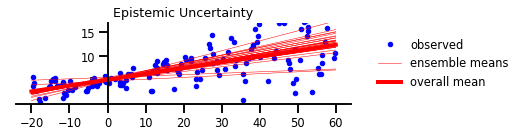

In [29]:
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 25:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.title("Epistemic Uncertainty")

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)

위의 그래프의 흥미로운 점은 모델이 예측할 때마다 다른 결과가 나온다는 것이다. 
왜냐하면 DenseVariational은 기본적으로 모델의 앙상블을 정의하기 때문이다.  
각 선은 사후분포에서의 모델 매개변수의 다른 무작위 결과를 나타낸다. 여러번의 모델 예측 결과를 이용해 x의 분포에 대한 각 구간의 불확실성을 나타낼 수 있다.

Case4 : Aleatoric & Epistemic Uncertainty

또한, TFP의 컴파일 가능한 API를 사용한여 두가지 불확실성을 동시에 학습하는 모델을 만들 수 있다.

In [31]:
# Build model.
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
    tfp.layers.DistributionLambda(
              lambda t: tfd.Normal(loc=t[..., :1],
                                   scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

In [32]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

In [33]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.13065335  2.689317    5.1712117   3.9084537  -3.5280435  -0.97595066
 -2.1345022  -0.26864034]
[0.1262337 2.6539614 5.1450815 3.746189 ]


이전 모델에서 유일한 변경사항은 DenseVariational 레이어를 출력층에 추가하여 라벨의 분포의 축척도 모델링했다는 것이다. 이전 결과와 같이 모델의 앙상블을 얻지만, 모두 y의 가변성을 계량할 수 있다.

In [ ]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
        plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.title("Both Uncertainty")
ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)

이 모델의 예측은 aleatoric uncertainty만 고려했던 모델의 예측과의 차이가 있다. 이 모델은 x의 epistemic uncertainty가 더 클 수록 더 많은 가변성을 예측한다. 이는 단순한 선형모델로는 수행할 수 없는 것이다.

### Conclusion

 TensorFlow Probability를 이용해서 가장 기본적인 선형회귀 모형에 대해 aleatoric, epistemic uncertainty를 계량해보았다. 단순히 입력값(x)에 대한 모델의 추정값(y)만 얻는 것이 아닌 데이터 측면의 불확실성, 모델 파라미터 측면의 불확실성을 측정해 모델의 추정값에 대한 폭넓은 활용이 가능해 보인다. 즉, 모델이 추정값만 제공하는 것이아닌, 다른 지표도 제공함으로서 값에 대한 신뢰성 측면에서의 이점을 얻을 수 있다 생각된다.  
 다음 글에선 TFP 패키지가 아닌 다른 방식의 불확실성 계량에 대해 기술해보겠다.